In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
from datetime import datetime
import urllib.request
import urllib.error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
import time
%matplotlib inline

In [2]:
#Dictionary of team names and abbreviations. VEG is used instead of VGK.
teamAbvs = {'Anaheim Ducks':'ANA', 'Arizona Coyotes':'ARI', 'Boston Bruins': 'BOS', 'Buffalo Sabres':'BUF', 'Carolina Hurricanes':'CAR',
            'Calgary Flames':'CGY', 'Chicago Blackhawks':'CHI', 'Columbus Blue Jackets':'CBJ', 'Colorado Avalanche':'COL', 'Dallas Stars':'DAL',
           'Detroit Red Wings':'DET', 'Edmonton Oilers':'EDM', 'Florida Panthers':'FLA', 'Los Angeles Kings':'LAK',
           'Minnesota Wild':'MIN', 'Montreal Canadiens':'MTL', 'Nashville Predators':'NSH', 'New Jersey Devils':'NJD',
           'New York Islanders':'NYI', 'New York Rangers':'NYR', 'Ottawa Senators':'OTT', 'Phoenix Coyotes':'PHX', 'Philadelphia Flyers':'PHI',
           'Pittsburgh Penguins':'PIT', 'San Jose Sharks':'SJS', 'St. Louis Blues':'STL', 'Tampa Bay Lightning':'TBL',
           'Toronto Maple Leafs':'TOR','Vancouver Canucks':'VAN', 'Vegas Golden Knights':'VEG', 'Washington Capitals':'WSH', 'Winnipeg Jets':'WPG',
           }

In [3]:
def startSeason(season_url):
    season_year = season_url.split('_')[1]
    
    #Retrieving the initial url and HTML.
    try:
        season_page = urlopen(season_url)
    except urllib.error.URLError:
        return print('Error with URL')
        
    season_soup = BeautifulSoup(season_page)
    
    #Building the schedule table.
    season_games = season_soup.find(id='games')
    Date =[]
    Vis=[]
    VG=[]
    Home=[]
    HG=[]
    OT=[]
    Att=[]
    LOG=[]
    Notes=[]

    #Create a table with a list for each column of data.
    headers = [Date, Vis, VG, Home, HG, OT, Att, LOG, Notes]
    
    #Iterate through each row and column, assigning the corresponding data to the location in 'headers'.
    for row in season_games.findAll('tr'):
        cells = row.findAll(['td','th'])
        index = np.arange(0,len(cells)).tolist()
        for num in index:
            headers[num].append(cells[num].find(text=True))
            
    #Create the games Dataframe, set the column names to names instead of index values.
    season_gamesDf = pd.DataFrame(headers).transpose()
    season_gamesDf.columns = season_gamesDf.iloc[0]
    season_gamesDf = season_gamesDf.reindex(season_gamesDf.index.drop(0))
    
    #Create game HTML string for every game.
    gameHTML = []
    for entry in season_gamesDf.index:
        abv = teamAbvs[season_gamesDf['Home'][entry]]
        daystr = ''.join(season_gamesDf['Date'][entry].split('-'))
        gamestr = (daystr+'0'+abv)
        gamepage = ('https://www.hockey-reference.com/boxscores/'+gamestr+'.html')
        gameHTML.append(gamepage)
    #Add the new gameHTML column to gamesDf.
    season_gamesDf['Game HTML'] = gameHTML
    number_of_games = len(gameHTML)

    #Create the penalty columns for each game and the columns for running totals of each penalty.
    initialCalls = np.zeros(number_of_games)
    initialCalls.tolist()
    season_gamesDf['Slashing Calls in Game'] = initialCalls 
    season_gamesDf['Total Slashing Calls'] = initialCalls  

    season_gamesDf['roughing Calls in Game'] = initialCalls 
    season_gamesDf['Total roughing Calls'] = initialCalls 

    season_gamesDf['hooking Calls in Game'] = initialCalls  
    season_gamesDf['Total hooking Calls'] = initialCalls  

    season_gamesDf['interfering Calls in Game'] = initialCalls  
    season_gamesDf['Total interfering Calls'] = initialCalls  

    season_gamesDf['tripping Calls in Game'] = initialCalls  
    season_gamesDf['Total tripping Calls'] = initialCalls  

    season_gamesDf['highsticking Calls in Game'] = initialCalls  
    season_gamesDf['Total highsticking Calls'] = initialCalls 

    season_gamesDf['fighting Calls in Game'] = initialCalls 
    season_gamesDf['Total fighting Calls'] = initialCalls
    
    season_gamesDf['Updated'] = initialCalls
    
    #Get all the column names for the overall penalty table.
    penalty_columns = season_gamesDf.columns.tolist()

    #Output the dataframe object with all of the retrieved data.
    season_gamesDf.to_csv('NHL_penalties_'+season_year, index=False,  header=penalty_columns)
    
    #Creating an empty dataframe of penalties for each team in the season.
    teams = sorted(list(teamAbvs.values()))
    penalties = ['slashing', 'hooking', 'tripping', 'sticking', 'interference', 'roughing', 'fighting', 'total']
    games = np.arange(1,number_of_games+1,1)
    team_penalties = pd.DataFrame(np.zeros((number_of_games,256), dtype='int32'),
                                  index=games,
                                  columns=pd.MultiIndex.from_product([teams, penalties], names=['Team', 'Penalty'])
                                 )
    
    team_penalties.to_csv('team_penalties_'+season_year, index=False)

In [4]:
def updateSeason(season_url):
    start = datetime.now()
    #Need to check that the season has already been 'started' by startSeason() and the dfs exist.
    import os.path
    season_year = season_url.split('_')[1]
    
    season_df_name = 'NHL_penalties_'+season_year
    team_season_df = 'team_penalties_'+season_year
    
    if os.path.isfile(season_df_name) == False:
        return 'Season data does not exist, has the season been initialized with startSeason?'
    else:
        local_season_df = pd.read_csv(season_df_name)
    if os.path.isfile(team_season_df) == False:
        return 'Teams data does not exist, has the season been initialized?'
    else:
        local_team_season_df = pd.read_csv(team_season_df, header=[0,1])
        
    #Convert season date column to a datetime object.
    local_season_df['Date'] = pd.to_datetime(local_season_df['Date'], infer_datetime_format=True)
    
    #Find the last row with valid data and pick the next one as the next row to be entered.
    next_entry = (local_season_df['Updated'].values != 1).argmax()
    columns = local_season_df.columns.tolist()
    
    #Need to rebuild the existing online table to compare to local data.
    #Retrieving the initial url and HTML.
    try: 
        season_page = urlopen(season_url)
    except urllib.error.URLError:
        return print('Error with URL')
    
    season_soup = BeautifulSoup(season_page, 'lxml')
    
    #Building the schedule table
    season_games = season_soup.find(id='games')
    Date =[]
    Vis=[]
    VG=[]
    Home=[]
    HG=[]
    OT=[]
    Att=[]
    LOG=[]
    Notes=[]

    #Create a table with a list for each column of data.
    headers = [Date, Vis, VG, Home, HG, OT, Att, LOG, Notes]
    
    #Iterate through each row and column, assigning the corresponding data to the location in 'headers'.
    for row in season_games.findAll('tr'):
        cells = row.findAll(['td','th'])
        index = np.arange(0,len(cells)).tolist()
        for num in index:
            headers[num].append(cells[num].find(text=True))
            
    #Create the games Dataframe, set the column names to names instead of index values.
    season_gamesDf = pd.DataFrame(headers).transpose()
    season_gamesDf.columns = season_gamesDf.iloc[0]
    season_gamesDf = season_gamesDf.reindex(season_gamesDf.index.drop(0))
    
    #Convert the date column to a datetime object for comparisons
    season_gamesDf['Date'] = pd.to_datetime(season_gamesDf['Date'], infer_datetime_format=True)
    
    #Find the most recent game updated. Defines the span of games which need to be updated.
    latest_entry = season_gamesDf['Att.'].last_valid_index()
    
    #Fill the NaN attendence values with an easy to look for placeholder
    season_gamesDf['Att.'].fillna(0, inplace=True)
    
    #Make the list of teams and penalties to be compared against while updating.
    teams = sorted(list(teamAbvs.values()))
    penalties = ['slashing', 'hooking', 'tripping', 'sticking', 'interference', 'roughing', 'fighting']

    #Begin looping through the games.
    while next_entry < latest_entry:
        print(next_entry)
        #Check if game was postponed/rescheduled
        #if (season_gamesDf['Date'][next_entry] < datetime.now()) and (season_gamesDf['Att'][next_entry] == 0):
         #   season_gamesDf.drop([next_entry], inplace=True)
          #  season_gamesDf = season_gamesDf.reset_index(drop=True)
           # season_gamesDf.index += 1
            
        gamepage = local_season_df['Game HTML'][next_entry]
        try:
            openedgame = urlopen(gamepage)
        except urllib.error.URLError:
            return print('Error with URL')
        
        gamesoup = BeautifulSoup(openedgame)    
        penaltytable = gamesoup.find(id='penalty')
        
        #Initialize an empty penalty dictionary for each game.
        penalty_dict = {
            'slashing':0,
            'hooking':0,
            'tripping':0,
            'sticking':0,
            'interference':0,
            'roughing':0,
            'fighting':0
        }
        
        #Going through the penalty entries to find calls.
        for row in penaltytable.findAll('tr'):
            rowtext = row.get_text().lower().split()
            #Record the call made on each line of the penalty table and update the value in the dictionary
            call = [word for word in rowtext if word in penalties]
            if len(call) > 0:
                penalty_dict[call[0]] += 1
                #Record the team who it was called on
                name = [word.upper() for word in rowtext if word.upper() in teams]
                local_team_season_df[name[0]].iloc[next_entry][call[0]] += 1 
            
        #Adding relevant entries to each list.
        #Using next_entry values to avoid indexing issues.
        #Updating in game totals.
        local_season_df['Slashing Calls in Game'][next_entry] = penalty_dict['slashing']
        local_season_df['roughing Calls in Game'][next_entry] = penalty_dict['roughing']
        local_season_df['hooking Calls in Game'][next_entry] = penalty_dict['hooking']
        local_season_df['interfering Calls in Game'][next_entry] = penalty_dict['interference']
        local_season_df['tripping Calls in Game'][next_entry] = penalty_dict['tripping']
        local_season_df['highsticking Calls in Game'][next_entry] = penalty_dict['sticking']
        local_season_df['fighting Calls in Game'][next_entry] = penalty_dict['fighting']
        
        #Updating full season totals.
        if next_entry == 1:
            local_season_df['Total Slashing Calls'].iloc[next_entry] = penalty_dict['slashing']
            local_season_df['Total roughing Calls'].iloc[next_entry] = penalty_dict['roughing']
            local_season_df['Total hooking Calls'].iloc[next_entry] = penalty_dict['hooking']
            local_season_df['Total interfering Calls'].iloc[next_entry] = penalty_dict['interference']
            local_season_df['Total tripping Calls'].iloc[next_entry] = penalty_dict['tripping']
            local_season_df['Total highsticking Calls'].iloc[next_entry] = penalty_dict['sticking']
            local_season_df['Total fighting Calls'].iloc[next_entry] = penalty_dict['fighting']
        else:
            local_season_df['Total Slashing Calls'].iloc[next_entry] += penalty_dict['slashing']
            local_season_df['Total roughing Calls'].iloc[next_entry] += penalty_dict['roughing']
            local_season_df['Total hooking Calls'].iloc[next_entry] += penalty_dict['hooking']
            local_season_df['Total interfering Calls'].iloc[next_entry] += penalty_dict['interference']
            local_season_df['Total tripping Calls'].iloc[next_entry] += penalty_dict['tripping']
            local_season_df['Total highsticking Calls'].iloc[next_entry] += penalty_dict['sticking']
            local_season_df['Total fighting Calls'].iloc[next_entry] += penalty_dict['fighting']
        
        #Marking the game as 'updated'.
        local_season_df['Updated'].iloc[next_entry] = 1.0
        
        #Increment to the next entry
        next_entry += 1
    
    #Save the updated data and overwrite the previous file.
    local_season_df.to_csv('NHL_penalties_'+season_year, index = False,  header=columns)
    local_team_season_df.to_csv('team_penalties_'+season_year, index=False)
    print(datetime.now() - start)

In [ ]:
#Proof of concept cell
startSeason('https://www.hockey-reference.com/leagues/NHL_2016_games.html')
updateSeason('https://www.hockey-reference.com/leagues/NHL_2016_games.html')

0


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Se

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
##Want to update with: handling of cancelled games -> weird case...

In [5]:
#Update script to run overnight, update the previous 4 seasons.
years = [2015, 2016, 2017, 2018]
for year in years:
    year = str(year)
    url = 'https://www.hockey-reference.com/leagues/NHL_'+year+'_games.html'
    startSeason(url)
    updateSeason(url)

0


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Se

1


KeyboardInterrupt: 

In [ ]:
import cufflinks as cf
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [8]:
#Beginning of plotting code. Will need to recollect with fixed highsticking code, need to be able to take multiple
#years, teams, etc. 
def teamPlot(names, years):
    names = names.upper()
    bardata = []
    for year in years:
        #year = str(year)
        team_data = pd.read_csv('team_penalties_'+year, header=[0,1])
        wanted_team = team_data[names]
        penalties = wanted_team.columns.drop('total')
        totals = []
        for penalty in penalties:
            totals.append(wanted_team[penalty].sum())
        year_bar_plot = go.Bar(x=penalties, y=totals, name=year, text=totals, textposition='auto')
        bardata.append(year_bar_plot)
    
    barlayout = go.Layout(barmode='group', title = 'Penalty Calls - '+names,
                        yaxis = dict(title='Number of Calls', showgrid=True, linecolor='black', linewidth=2, mirror=True), 
                        xaxis = dict(title='Penalty', showgrid=True, linecolor='black', linewidth=2, mirror=True))
    barfig = dict(data=bardata, layout=barlayout)
    iplot(barfig)

Index(['slashing', 'hooking', 'tripping', 'sticking', 'interference',
       'roughing', 'fighting'],
      dtype='object')


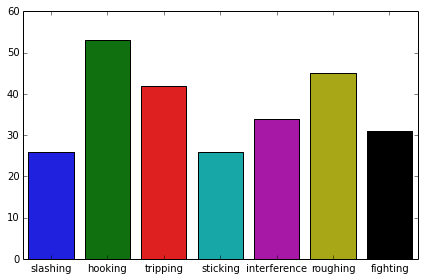

In [9]:
teamPlot('VAN', '2015')

In [ ]:
#Plot data for all teams for a given year
def yearPlot(year, penalty):
    teams_data = pd.read_csv('team_penalties_'+year, header=[0,1])
    teams = sorted(list(teamAbvs.values()))
    plot_data = pd.DataFrame()
    plot_data['Team'] = teams
    plot_data['Penalty Total'] = plot_data['Team'].apply(lambda team: teams_data[team][penalty].sum())
    teams_bar_plot = go.Bar(x=plot_data['Team'], y=plot_data['Penalty Total'], name=year, text=plot_data['Penalty Total'])
    bardata = [teams_bar_plot]
    barlayout = go.Layout(barmode='group', title = penalty+' Calls per Team',
                    yaxis = dict(title='Number of Calls', showgrid=True, linecolor='black', linewidth=2, mirror=True), 
                    xaxis = dict(title='Team', showgrid=True, linecolor='black', linewidth=2, mirror=True))
    barfig = dict(data=bardata, layout=barlayout)
    iplot(barfig)